In [21]:
# def calc_hard_dice(y_true, y_pred):
#     numerator = 2.0 * np.sum(np.round(y_true)*np.round(y_pred))
#     denominator = np.sum(np.round(y_true)) + np.sum(np.round(y_pred))
#     if denominator == 0:
#        return 1.0
#     else:
#        return numerator / denominator

# def calc_dice(y_true, y_pred, smooth=1):
#     """
#     Sorensen Dice coefficient
#     """
#     numerator = 2.0 * np.sum(y_true * y_pred) + smooth
#     denominator = np.sum(y_true) + np.sum(y_pred) + smooth
#     coef = numerator / denominator
    
#     print (numerator, denominator, coef)

#     return coef

def calc_hard_dice(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    numerator = 2.0 * np.sum(np.round(y_true)*np.round(y_pred))
    denominator = np.sum(np.round(y_true)) + np.sum(np.round(y_pred))
    if denominator == 0:
       return 1.0
    else:
       return numerator / denominator

def calc_dice(y_true, y_pred, smooth=1):
    """
    Sorensen Dice coefficient
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    numerator = 2.0 * np.sum(y_true * y_pred) + smooth
    denominator = np.sum(y_true) + np.sum(y_pred) + smooth
    coef = numerator / denominator

    return coef

def dice_coef(y_true, y_pred, axis=(1, 2), smooth=1):
    """
    Sorenson (Soft) Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.log(2.*numerator) + tf.log(denominator)

    return dice_loss


def combined_dice_ce_loss(y_true, y_pred, axis=(1, 2), smooth=1.,
                          weight=0.9):
    """
    Combined Dice and Binary Cross Entropy Loss
    """
    return weight*dice_coef_loss(y_true, y_pred, axis, smooth) + \
        (1-weight)*K.losses.binary_crossentropy(y_true, y_pred)


def plot_results(model, imgs_validation, msks_validation, img_no, png_directory):
    """
    Calculate the Dice and plot the predicted masks for image # img_no
    """

    img = imgs_validation[[img_no], ]
    msk = msks_validation[[img_no], ]

    pred_mask = model.predict(img)

    dice_score = calc_dice(pred_mask, msk)

    print("{:.4f}, {:.4f}".format(dice_score, calc_hard_dice(pred_mask, msk)))


In [30]:
# parser = argparse.ArgumentParser(
#     description="Inference example for trained 2D U-Net model on BraTS.",
#     add_help=True, formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# parser.add_argument("--data_path", default=settings.DATA_PATH,
#                     help="the path to the data")
# parser.add_argument("--data_filename", default=settings.DATA_FILENAME,
#                     help="the HDF5 data filename")
# parser.add_argument("--output_path", default=settings.OUT_PATH,
#                     help="the folder to save the model and checkpoints")
# parser.add_argument("--inference_filename", default=settings.INFERENCE_FILENAME,
#                     help="the Keras inference model filename")

# parser.add_argument("--intraop_threads", default=settings.NUM_INTRA_THREADS,
#                     type=int, help="Number of intra-op-parallelism threads")
# parser.add_argument("--interop_threads", default=settings.NUM_INTER_THREADS,
#                     type=int, help="Number of inter-op-parallelism threads")
import os

import numpy as np
import tensorflow as tf
import keras as K
import settings
import argparse
import h5py

import matplotlib.pyplot as plt

args = argparse.Namespace()
args.data_path="/home/bduser/tony/data/decathlon/"
args.data_filename="240x240/decathlon_brats.h5"
args.output_path="/home/bduser/tony/unet_tiling/"
args.inference_filename="unet_decathlon_4_8814_128x128_randomcrop.hdf5"
args.inference_filename="unet_decathlon_4_8814_128x128_randomcrop-fullimg.hdf5"
args.intraop_threads=5
args.interop_threads=2

CONFIG = tf.ConfigProto(
    inter_op_parallelism_threads=args.interop_threads,
    intra_op_parallelism_threads=args.intraop_threads)

SESS = tf.Session(config=CONFIG)
K.backend.set_session(SESS)

data_fn = os.path.join(args.data_path, args.data_filename)
model_fn = os.path.join(args.output_path, args.inference_filename)

# Load data
print("Loading Data... ")
df = h5py.File(data_fn, "r")
imgs_validation = df["imgs_validation"]
msks_validation = df["msks_validation"]
print("Data loaded successfully from: " + data_fn)

# Load model
print("Loading Model... ")
model = K.models.load_model(model_fn, custom_objects={
    "combined_dice_ce_loss": combined_dice_ce_loss,
    "dice_coef_loss": dice_coef_loss,
    "dice_coef": dice_coef})
print("Model loaded successfully from: " + model_fn)

# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)

# Plot some results
# The plots will be saved to the png_directory
# Just picking some random samples.
indicies_validation = [40, 61, 400, 1100, 4385,
                       5566, 5673, 6433, 7864, 8899, 9003, 9722, 10591]




Loading Data... 
Data loaded successfully from: /home/bduser/tony/data/decathlon/240x240/decathlon_brats.h5
Loading Model... 


OSError: Unable to open file (unable to open file: name = '/home/bduser/tony/unet_tiling/unet_decathlon_4_8814_128x128_randomcrop-fullimg.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [23]:

print("Number of validation images: ", imgs_validation.shape[0])

Number of validation images:  12090


In [29]:
full_img = msks_validation[[10], ]
full_img.shape
df.keys()

<KeysViewHDF5 ['description', 'imgs_train', 'imgs_validation', 'license', 'modalities', 'msks_train', 'msks_validation', 'name', 'reference', 'release', 'tensorImageSize', 'training_input_files', 'training_label_files', 'validation_input_files', 'validation_label_files']>

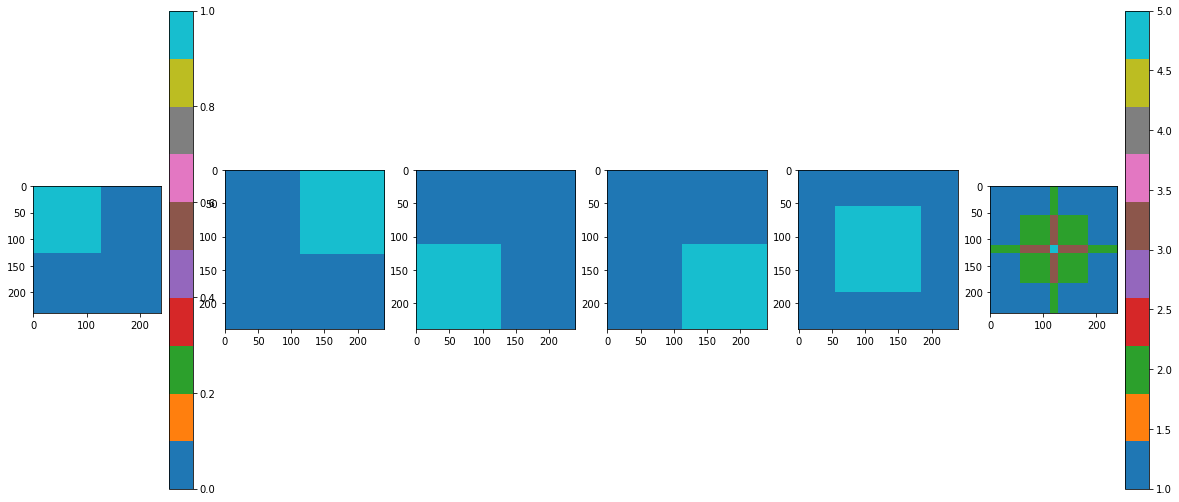

In [39]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

full_img = imgs_validation[[1], ]
_, x, y, _ = full_img.shape

cropx = 128
cropy = 128

data = np.zeros((240,240))
data[0:cropx, 0:cropy] = 1
tl = data

data = np.zeros((240,240))
data[0:cropx, y-cropy:y] = 1
tr = data

data = np.zeros((240,240))
data[x-cropx:x, 0:cropy] = 1
bl = data

data = np.zeros((240,240))
data[x-cropx:x, y-cropy:y] = 1
br = data

data = np.zeros((240,240))
startx = x//2-(cropx//2)
starty = y//2-(cropy//2)    
data[starty:starty+cropy,startx:startx+cropx] = 1
cc = data

data = np.zeros((240,240))
five_patch_divisor = tl + tr + bl + br + cc

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

tl_fig = axes[0, 0].imshow(tl, cmap='tab10', interpolation='nearest')
axes[0, 1].imshow(tr, cmap='tab10', interpolation='nearest')
axes[1, 0].imshow(bl, cmap='tab10', interpolation='nearest')
axes[1, 1].imshow(br, cmap='tab10', interpolation='nearest')
axes[2, 0].imshow(cc, cmap='tab10', interpolation='nearest')
five_patches_fig = axes[2, 1].imshow(five_patch_divisor, cmap='tab10', interpolation='nearest')

fig.colorbar(tl_fig, ax=axes[0, 0])
fig.colorbar(five_patches_fig, ax=axes[2, 1])


In [6]:
def crop_tl(img, cropx, cropy):
    _, x, y, _ = img.shape
    return img[:, 0:cropx, 0:cropy]

def crop_tr(img, cropx, cropy):
    _, x, y, _ = img.shape
    return img[:, 0:cropx, y-cropy:y]

def crop_bl(img, cropx, cropy):
    _, x, y, _ = img.shape
    return img[:, x-cropx:x, 0:cropy]

def crop_br(img, cropx, cropy):
    _, x, y, _ = img.shape
    return img[:, x-cropx:x, y-cropy:y]

def crop_c(img, cropx, cropy):
    _, y, x, _ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:,starty:starty+cropy,startx:startx+cropx]

def calc_dice_scores(pred_mask, msk):
    dice_score = calc_dice(pred_mask, msk)
    hard_dice_score = calc_hard_dice(pred_mask, msk)
    return dice_score, hard_dice_score 

def print_avg_dice_scores(dice_results):
    dice_results = np.asarray(dice_results)
    avg_dice = np.average(dice_results[:,1])
    avg_hard_dice = np.average(dice_results[:,2])
    print("Avg Dice Score: {:.4f},\nAvg Hard Dice Score: {:.4f}".format(avg_dice, avg_hard_dice))    
    

In [18]:
from tqdm import tqdm

cropx = 128
cropy = 128

def elwise_round_thres(arr, threshold):
    arr[arr >= threshold] = 1
    arr[arr < threshold] = 0
    
    return arr

dice_results_round_after_avg = []
dice_results_round_before_avg = []

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8] 
#thresholds = [0.3] 

for threshold in thresholds:
    for img_id in tqdm(range(240,280)):
    #for img_id in tqdm(range(imgs_validation.shape[0])):

        full_img = imgs_validation[[img_id], ]
        full_msk = msks_validation[[img_id], ]
        _, x, y, _ = full_img.shape

        tl_img = crop_tl(full_img, cropx, cropy)
        tl_msk = crop_tl(full_msk, cropx, cropy)

        pred_tl_msk = model.predict(tl_img)
        pred_tl_mask_placehld = np.zeros((240,240))
        pred_tl_mask_placehld[0:cropx, 0:cropy]=pred_tl_msk[0][:,:,0]

        tr_img = crop_tr(full_img, cropx, cropy)
        tr_msk = crop_tr(full_msk, cropx, cropy)

        pred_tr_msk = model.predict(tr_img)
        pred_tr_mask_placehld = np.zeros((240,240))
        pred_tr_mask_placehld[0:cropx, y-cropy:y]=pred_tr_msk[0][:,:,0]

        bl_img = crop_bl(full_img, cropx, cropy)
        bl_msk = crop_bl(full_msk, cropx, cropy)

        pred_bl_msk = model.predict(bl_img)
        pred_bl_mask_placehld = np.zeros((240,240))
        pred_bl_mask_placehld[x-cropx:x, 0:cropy]=pred_bl_msk[0][:,:,0]

        br_img = crop_br(full_img, cropx, cropy)
        br_msk = crop_br(full_msk, cropx, cropy)

        pred_br_msk = model.predict(br_img)
        pred_br_mask_placehld = np.zeros((240,240))
        pred_br_mask_placehld[x-cropx:x, y-cropy:y]=pred_br_msk[0][:,:,0]

        cc_img = crop_c(full_img, cropx, cropy)
        cc_msk = crop_c(full_msk, cropx, cropy)

        pred_cc_msk = model.predict(cc_img)
        pred_cc_mask_placehld = np.zeros((240,240))
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)  
        pred_cc_mask_placehld[startx:startx+cropx, starty:starty+cropy]=pred_cc_msk[0][:,:,0]

        # Round after averaging
        pred_full_msk = pred_tl_mask_placehld + pred_tr_mask_placehld + pred_bl_mask_placehld + pred_br_mask_placehld + pred_cc_mask_placehld
        pred_full_msk_avg = pred_full_msk // five_patch_divisor
        pred_full_msk_avg = elwise_round_thres(pred_full_msk_avg, threshold)

        dice_score, hard_dice_score = calc_dice_scores(pred_full_msk_avg, full_msk)
        dice_results_round_after_avg.append([img_id, dice_score, hard_dice_score])

        # Round before averaging
        pred_full_msk = []
        pred_full_msk = elwise_round_thres(pred_tl_mask_placehld, threshold) + elwise_round_thres(pred_tr_mask_placehld, threshold) + elwise_round_thres(pred_bl_mask_placehld, threshold) + elwise_round_thres(pred_br_mask_placehld, threshold) + elwise_round_thres(pred_cc_mask_placehld, threshold)
        pred_full_msk_avg = pred_full_msk // five_patch_divisor

        dice_score, hard_dice_score = calc_dice_scores(pred_full_msk_avg, full_msk)
        dice_results_round_before_avg.append([img_id, dice_score, hard_dice_score])

    print("\nThreshold: ", threshold)
    print ("dice_results_round_after_avg")
    print_avg_dice_scores(dice_results_round_after_avg)

    print ("\ndice_results_round_before_avg")
    print_avg_dice_scores(dice_results_round_before_avg)


  2%|▎         | 1/40 [00:00<00:05,  7.50it/s]


Threshold:  0.3
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8687,
Avg Hard Dice Score: 0.8623


  2%|▎         | 1/40 [00:00<00:04,  7.97it/s]


Threshold:  0.35
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8692,
Avg Hard Dice Score: 0.8628


  2%|▎         | 1/40 [00:00<00:04,  8.06it/s]


Threshold:  0.4
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8696,
Avg Hard Dice Score: 0.8632


  2%|▎         | 1/40 [00:00<00:05,  7.77it/s]


Threshold:  0.45
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8700,
Avg Hard Dice Score: 0.8636


  2%|▎         | 1/40 [00:00<00:04,  7.97it/s]


Threshold:  0.5
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8705,
Avg Hard Dice Score: 0.8641


  2%|▎         | 1/40 [00:00<00:04,  7.92it/s]


Threshold:  0.55
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8710,
Avg Hard Dice Score: 0.8646


  2%|▎         | 1/40 [00:00<00:04,  7.89it/s]


Threshold:  0.6
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8714,
Avg Hard Dice Score: 0.8650


  2%|▎         | 1/40 [00:00<00:04,  7.84it/s]


Threshold:  0.65
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8719,
Avg Hard Dice Score: 0.8655


  2%|▎         | 1/40 [00:00<00:04,  8.04it/s]


Threshold:  0.7
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8724,
Avg Hard Dice Score: 0.8660


  2%|▎         | 1/40 [00:00<00:04,  7.96it/s]


Threshold:  0.75
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8728,
Avg Hard Dice Score: 0.8664


  2%|▎         | 1/40 [00:00<00:04,  8.00it/s]


Threshold:  0.8
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8734,
Avg Hard Dice Score: 0.8670


  2%|▎         | 1/40 [00:00<00:04,  7.90it/s]


Threshold:  0.85
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8739,
Avg Hard Dice Score: 0.8675


100%|██████████| 40/40 [00:05<00:00,  8.07it/s]


Threshold:  0.9
dice_results_round_after_avg
Avg Dice Score: 0.3384,
Avg Hard Dice Score: 0.3308

dice_results_round_before_avg
Avg Dice Score: 0.8746,
Avg Hard Dice Score: 0.8682


In [8]:
from tqdm import tqdm

cropx = 128
cropy = 128

def elwise_round_thres(arr, threshold):
    arr[arr >= threshold] = 1
    arr[arr < threshold] = 0
    
    return arr

elwise_round = np.vectorize(round, otypes=[np.int])

dice_results_round_after_avg = []
dice_results_round_before_avg = []

for img_id in tqdm(range(240,250)):
#for img_id in tqdm(range(imgs_validation.shape[0])):
   
    full_img = imgs_validation[[img_id], ]
    full_msk = msks_validation[[img_id], ]
    _, x, y, _ = full_img.shape
    
    tl_img = crop_tl(full_img, cropx, cropy)
    tl_msk = crop_tl(full_msk, cropx, cropy)

    pred_tl_msk = model.predict(tl_img)
    pred_tl_mask_placehld = np.zeros((240,240))
    pred_tl_mask_placehld[0:cropx, 0:cropy]=pred_tl_msk[0][:,:,0]

    tr_img = crop_tr(full_img, cropx, cropy)
    tr_msk = crop_tr(full_msk, cropx, cropy)

    pred_tr_msk = model.predict(tr_img)
    pred_tr_mask_placehld = np.zeros((240,240))
    pred_tr_mask_placehld[0:cropx, y-cropy:y]=pred_tr_msk[0][:,:,0]

    bl_img = crop_bl(full_img, cropx, cropy)
    bl_msk = crop_bl(full_msk, cropx, cropy)

    pred_bl_msk = model.predict(bl_img)
    pred_bl_mask_placehld = np.zeros((240,240))
    pred_bl_mask_placehld[x-cropx:x, 0:cropy]=pred_bl_msk[0][:,:,0]

    br_img = crop_br(full_img, cropx, cropy)
    br_msk = crop_br(full_msk, cropx, cropy)

    pred_br_msk = model.predict(br_img)
    pred_br_mask_placehld = np.zeros((240,240))
    pred_br_mask_placehld[x-cropx:x, y-cropy:y]=pred_br_msk[0][:,:,0]

    cc_img = crop_c(full_img, cropx, cropy)
    cc_msk = crop_c(full_msk, cropx, cropy)

    pred_cc_msk = model.predict(cc_img)
    pred_cc_mask_placehld = np.zeros((240,240))
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)  
    pred_cc_mask_placehld[startx:startx+cropx, starty:starty+cropy]=pred_cc_msk[0][:,:,0]
    
    # Round after averaging
    pred_full_msk = pred_tl_mask_placehld + pred_tr_mask_placehld + pred_bl_mask_placehld + pred_br_mask_placehld + pred_cc_mask_placehld
    pred_full_msk_avg = pred_full_msk // five_patch_divisor
    pred_full_msk_avg = elwise_round(pred_full_msk_avg)
    
    dice_score, hard_dice_score = calc_dice_scores(pred_full_msk_avg, full_msk)
    dice_results_round_after_avg.append([img_id, dice_score, hard_dice_score])
    
    # Round before averaging
    pred_full_msk = []
    pred_full_msk = elwise_round(pred_tl_mask_placehld) + elwise_round(pred_tr_mask_placehld) + elwise_round(pred_bl_mask_placehld) + elwise_round(pred_br_mask_placehld) + elwise_round(pred_cc_mask_placehld)
    pred_full_msk_avg = pred_full_msk // five_patch_divisor

    dice_score, hard_dice_score = calc_dice_scores(pred_full_msk_avg, full_msk)
    dice_results_round_before_avg.append([img_id, dice_score, hard_dice_score])

print ("dice_results_round_after_avg")
print_avg_dice_scores(dice_results_round_after_avg)

print ("\ndice_results_round_before_avg")
print_avg_dice_scores(dice_results_round_before_avg)


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]

dice_results_round_after_avg
Avg Dice Score: 0.2969,
Avg Hard Dice Score: 0.2966

dice_results_round_before_avg
Avg Dice Score: 0.9248,
Avg Hard Dice Score: 0.9248


In [8]:
dice_results_round_after_avg_arr = np.asarray(dice_results_round_after_avg)
np.savetxt("dice_results_round_after_avg_arr.csv", dice_results_round_after_avg_arr, delimiter="," )

dice_results_round_before_avg_arr = np.asarray(dice_results_round_before_avg)
np.savetxt("dice_results_round_before_avg_arr.csv", dice_results_round_before_avg_arr, delimiter="," )

In [ ]:
import pandas as pd
import pandas_profiling   

elwise_round = np.vectorize(round, otypes=[np.int])
rounded = (elwise_round(pred_tl_msk[0][:,:,0]))
rounded_df= pd.DataFrame(rounded)
rounded_df.describe(include='all')

In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(dice_results_round_after_avg_arr[:,1])
sns.distplot(dice_results_round_after_avg_arr[:,2])

In [ ]:
import pandas as pd
import pandas_profiling
dice_results_df= pd.DataFrame(dice_results)
pandas_profiling.ProfileReport(dice_results_df)